<a href="https://colab.research.google.com/github/Andy-Tsunami/UTS-DataAnalytics-13110642/blob/master/Assignment2_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Assignment 2 - Pratical Machine Learning Project
## Modelling to Predict Flight Delays

###Advanced Data Analytics 32513

###Kai-Chieh Chang - 13310115
###Andy Tsui - 13110642

##Introduction
At an Airport there are limited gates available for aircraft to arrive and depart. A schedule is planned each day based on flights scheduled arrival and departure times. In theory if every aircraft arrives on time and departs on time, every aircraft in the schedule will have a gate available when they arrive, however in reality this is not the case. Flights often arrive or depart off schedule which can impact airport operations. An example would be a flight  is scheduled to depart at 06:00 but is delayed 1 hour because of a technical issue with the aircraft. The gate the delayed flight is on, has a flight arriving at 06:15, but because the departing flight on the gate is delayed, the arriving flight will need to either wait 45 minutes or change to another gate; which may not be possible if the airport is very busy and all other gates are occupied with other aircraft.

This project will look at data of departing flights to develop a machine learning model to try and predict if a departing flight will be delayed based on historical data. A Link to the Github report can be accessed here: 

https://github.com/Andy-Tsunami/UTS-DataAnalytics-13110642/blob/master/Assignment2_Final.ipynb


##Exploration
The challenges of implementation in this project is data preprocessing and choosing the algorithms. As we see in the dataset, some data of the attributes are blank. One reason is that our scope is focused on international flights and some attributes are only used when looking at domestic flights. Therefore, these empty attributes will not be used in our analysis. Another problem is missing data. Null will initially be used to replace the missing data when we implement the project, but to build the models, we will later replace Null with ‘0’. Some attributes we used to train our model has only a small portion of missing data. We consider that will not be a critical factor for training the model. Some attributes which has a large portion of missing data are considered identical or similar to our class attribute so that we do not use them in our training dataset. Finally, we need to implement some data transformation of unfamiliar data type, such as transforming date to an integer so that we can continue our binary solution.

##Methodology
This section will now provide the coding and methodology for developing the machine learning models.

###Uploading the Data

In [0]:
try:
    import plotly
    major_plotly_version = int(plotly.__version__.split('.')[0])
    assert major_plotly_version >= 4
except:
    !pip install plotly==4.1.0
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from datetime import datetime, date, time, timedelta
from sklearn.model_selection import train_test_split
import sklearn_pandas as skp
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
COLAB = True


In [0]:
#Uploading the data
url = 'https://raw.githubusercontent.com/Andy-Tsunami/UTS-DataAnalytics-13110642/master/DEPARTURES.csv'
df = pd.read_csv(url)
#To show a glimpse of the dataset and its attributes.
df.head()

,Flight_No,Callsign,Origins,Airports,Int_Dom,FltTyp,Date,Sched_Time,Est_Date,Est_Time,COBT_EST_DATETIME,Off_Chks_Date,OFF_BLOCK,Act_Date,Act_Time,PROV_TOTAL_PAX,Regn,AC_TYPE,STATUS,Public,Terminal,STAND,Position,Gate,Avail_Desks
0,EK415,UAE8JH,Dubai,DXB,I,J,1/03/2019,6:00,NaN,NaN,NaN,1/03/2019,5:58,1/03/2019,6:17,409.0,A6EET,388,A,N,T1,57,NaN,57,E1-E12
1,FJ914,FJI914,Nadi,NAN,I,J,1/03/2019,6:15,NaN,NaN,NaN,1/03/2019,6:12,1/03/2019,6:25,160.0,DQFJM,73H,A,N,T1,31,NaN,31,A13-A16
2,PO240,PAC240,Tokyo,NRT,I,F,1/03/2019,6:30,NaN,NaN,NaN,1/03/2019,6:32,1/03/2019,6:50,0.0,N643GT,76Y,A,N,T1,1,NaN,NaN,NaN
3,HU448,CHH448,Haikou Taiyuan/Wusu,HAK TYN,I,J,1/03/2019,7:55,NaN,NaN,NaN,1/03/2019,7:57,1/03/2019,8:14,146.0,B5950,333,A,N,T1,30,NaN,30,G10-G15
4,QF141,QFA141,Auckland,AKL,I,J,1/03/2019,7:55,NaN,NaN,NaN,1/03/2019,7:57,1/03/2019,8:23,157.0,VHVZV,738,A,N,T1,63,NaN,63,C1-C4


###Exploring the Data

In [0]:
#To explore the data, a query to the number of flights for each flight number is done.
df['Flight_No'].value_counts()

LA800      124
QF25       122
QF121      122
NH880      122
QF139      122
EK412      122
AC34       122
QF147      122
MU562      122
QF145      122
KE122      122
SQ222      122
SQ288      122
QR906      122
QF81       122
QF143      122
CZ326      122
FJ910      122
EY451      122
EY455      122
DL40       122
TG476      122
OZ602      122
CX138      122
CX100      122
AA72       122
QF117      122
QF141      122
VA141      122
SQ232      122
          ... 
NZ6016       1
ASY602       1
NZ6066       1
BSK260       1
NZ6052       1
QF25D        1
FX9177       1
QF6033       1
QR2909       1
SQ7294       1
UA2739       1
QF7340       1
VA171R       1
NAB006       1
JQ7143       1
VA9584       1
FX9147       1
QF7558       1
BOXER43      1
NZ6000       1
PX6002       1
5X6035       1
ASY445       1
JQ8999       1
EK8413       1
TFR132       1
FJ1961       1
EK9242       1
MF802A       1
HJ82         1
Name: Flight_No, Length: 324, dtype: int64

In [0]:
#To reduce the number of different values, flight numbers will be catergorised by airline
df['Airline']=df['Flight_No'].str[:2]
df['Airline'].value_counts()

QF    3771
VA    1083
NZ    1047
SQ     775
JQ     701
EK     599
CX     489
MU     376
QR     369
FJ     295
MH     278
UA     270
CZ     264
EY     244
FX     198
GA     193
CA     178
VN     170
CI     151
PR     150
D7     128
AA     124
LA     124
DL     124
KE     122
OZ     122
HA     122
NH     122
TG     122
AC     122
BA     122
JL     122
NF     114
5X     111
HU     102
TF     101
MF     101
AI      89
5J      87
HJ      84
PO      73
SB      52
TR      50
AS      41
JD      40
PX      36
OL      35
3U      34
HT      32
GS       6
NA       2
PF       1
ZL       1
BS       1
DN       1
BO       1
SA       1
5Y       1
Name: Airline, dtype: int64

In [0]:
#Creating a new column "Day_of_week" to show the day of the week taken from the date.
df['Date']= pd.to_datetime(df['Date'], format="%d/%m/%Y")
df['Day_of_week']=df['Date'].dt.dayofweek

In [0]:
#Creating a two new columns; "otp" (on time performance) to show how minutes 
#early or late the flight departed compared to its scheduled time and 
#"On_Time" that indicates if a flight departed on time - 1 = Yes and 0 = No.
Sched = pd.to_datetime(df['Sched_Time'])
OffB = pd.to_datetime(df['OFF_BLOCK'])
df['otp'] = OffB - Sched
def minute2binary(min):
  if min > 15: return 0
  else: return 1
df['On_Time'] = pd.to_timedelta(df['otp']).dt.total_seconds()//60
df['On_Time'] = df['On_Time'].apply(minute2binary)
df.head(25)

,Flight_No,Callsign,Origins,Airports,Int_Dom,FltTyp,Date,Sched_Time,Est_Date,Est_Time,COBT_EST_DATETIME,Off_Chks_Date,OFF_BLOCK,Act_Date,Act_Time,PROV_TOTAL_PAX,Regn,AC_TYPE,STATUS,Public,Terminal,STAND,Position,Gate,Avail_Desks,Airline,Day_of_week,otp,On_Time
0,EK415,UAE8JH,Dubai,DXB,I,J,2019-03-01,6:00,NaN,NaN,NaN,1/03/2019,5:58,1/03/2019,6:17,409.0,A6EET,388,A,N,T1,57,NaN,57,E1-E12,EK,4,-1 days +23:58:00,1
1,FJ914,FJI914,Nadi,NAN,I,J,2019-03-01,6:15,NaN,NaN,NaN,1/03/2019,6:12,1/03/2019,6:25,160.0,DQFJM,73H,A,N,T1,31,NaN,31,A13-A16,FJ,4,-1 days +23:57:00,1
2,PO240,PAC240,Tokyo,NRT,I,F,2019-03-01,6:30,NaN,NaN,NaN,1/03/2019,6:32,1/03/2019,6:50,0.0,N643GT,76Y,A,N,T1,1,NaN,NaN,NaN,PO,4,00:02:00,1
3,HU448,CHH448,Haikou Taiyuan/Wusu,HAK TYN,I,J,2019-03-01,7:55,NaN,NaN,NaN,1/03/2019,7:57,1/03/2019,8:14,146.0,B5950,333,A,N,T1,30,NaN,30,G10-G15,HU,4,00:02:00,1
4,QF141,QFA141,Auckland,AKL,I,J,2019-03-01,7:55,NaN,NaN,NaN,1/03/2019,7:57,1/03/2019,8:23,157.0,VHVZV,738,A,N,T1,63,NaN,63,C1-C4,QF,4,00:02:00,1
5,QR906,QTR906,Canberra,CBR,I,J,2019-03-01,7:55,NaN,NaN,NaN,1/03/2019,7:45,1/03/2019,7:59,0.0,A7BEO,77W,A,N,T1,36,NaN,36,NaN,QR,4,-1 days +23:50:00,1
6,CX110,CPA110,Hong Kong,HKG,I,J,2019-03-01,8:50,NaN,NaN,NaN,1/03/2019,8:47,1/03/2019,9:03,164.0,BLAC,333,A,N,T1,33,NaN,33,B1-B9,CX,4,-1 days +23:57:00,1
7,JQ119,JST119,Nadi,NAN,I,J,2019-03-01,8:55,NaN,NaN,NaN,1/03/2019,8:56,1/03/2019,9:20,105.0,VHVGJ,320,A,N,T1,55,NaN,55,J24-J28,JQ,4,00:01:00,1
8,VA181,VOZ181,Nadi,NAN,I,J,2019-03-01,8:30,1/03/2019,9:00,NaN,1/03/2019,8:50,1/03/2019,9:25,120.0,VHYIQ,73H,A,N,T1,53,NaN,53,J1-J14,VA,4,00:20:00,0
9,SQ212,SIA212,Singapore,SIN,I,J,2019-03-01,9:05,NaN,NaN,NaN,1/03/2019,8:53,1/03/2019,9:11,238.0,9VSWU,77W,A,N,T1,58,NaN,58,K15-K28,SQ,4,-1 days +23:48:00,1


In [0]:
#A List of the attributes in the dataframe.
print(df.dtypes)

Flight_No                     object
Callsign                      object
Origins                       object
Airports                      object
Int_Dom                       object
FltTyp                        object
Date                  datetime64[ns]
Sched_Time                    object
Est_Date                      object
Est_Time                      object
COBT_EST_DATETIME            float64
Off_Chks_Date                 object
OFF_BLOCK                     object
Act_Date                      object
Act_Time                      object
PROV_TOTAL_PAX               float64
Regn                          object
AC_TYPE                       object
STATUS                        object
Public                        object
Terminal                      object
STAND                         object
Position                     float64
Gate                          object
Avail_Desks                   object
Airline                       object
Day_of_week                    int64
o

In [0]:
#A snapshot of select flights and their on time performance (otp) shown as a scatter plot chart.   
qf_data=df.loc[df['FltTyp'] == "J"]
px.scatter(qf_data.query('Flight_No == ["QF1","QF7", "QF81", "QF63"]'),
           x="Date" , y="otp", color="Flight_No")


Text(0, 0.5, 'Count')

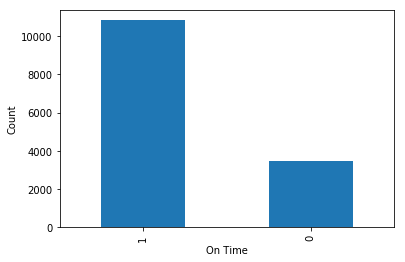

In [0]:
#Bar graph showing how many flights in the data set are on time and how many delayed - 1 = Yes, 0 = No.
pd.value_counts(df["On_Time"]).plot.bar()
plt.xlabel('On Time')
plt.ylabel('Count')

###Cleaning and Transforming the Data

In [0]:
#Preparing data to be used in classifiers.
le = LabelEncoder()

le.fit(df['Airline'].astype(str))
df['Airline'] = le.transform(df['Airline'].astype(str))

le.fit(df['Callsign'].astype(str))
df['Callsign'] = le.transform(df['Callsign'].astype(str))

le.fit(df['Airports'].astype(str))
df['Airports'] = le.transform(df['Airports'].astype(str))

le.fit(df['FltTyp'].astype(str))
df['FltTyp'] = le.transform(df['FltTyp'].astype(str)) 

le.fit(df['Regn'].astype(str))
df['Regn'] = le.transform(df['Regn'].astype(str))

le.fit(df['AC_TYPE'].astype(str))
df['AC_TYPE'] = le.transform(df['AC_TYPE'].astype(str))

le.fit(df['Avail_Desks'].astype(str))
df['Avail_Desks'] = le.transform(df['Avail_Desks'].astype(str))

le.fit(df['STAND'].astype(str))
df['STAND'] = le.transform(df['STAND'].astype(str))

le.fit(df['Gate'].astype(str))
df['Gate'] = le.transform(df['Gate'].astype(str))

le.fit(df['PROV_TOTAL_PAX'].astype(str))
df['PROV_TOTAL_PAX'] = le.transform(df['PROV_TOTAL_PAX'].astype(str))

In [0]:
#Amending Sched_Time to an integer
df['Sched_Time'] = pd.to_datetime(df['Sched_Time'])
df['Sched_Time'] = pd.to_timedelta(df['Sched_Time']).dt.total_seconds()//60


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version



###Splitting Data

In [0]:
#Splitting the data into training and testing samples and selecting which attributes to use for learning. 
cols = ['Airline','Airports', 'FltTyp','Day_of_week', 'Sched_Time', 'AC_TYPE' ,'PROV_TOTAL_PAX', 'STAND' ,'Regn']
x=df[cols]
y = df['On_Time']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
x_train = x_train.fillna(0)
x_test = x_test.fillna(0)

In [0]:
#Below table shows the attributes that will be used to train and test the data.
x_train.head()

,Airline,Airports,FltTyp,Day_of_week,Sched_Time,AC_TYPE,PROV_TOTAL_PAX,STAND,Regn
5938,38,42,3,4,26157415.0,40,153,22,631
2846,13,39,3,0,26156690.0,9,103,10,503
1786,45,78,3,5,26156650.0,21,9,39,825
219,35,81,3,5,26157450.0,8,91,12,433
8578,47,29,3,6,26157105.0,36,182,10,310


###Logistic Regression Classifier

In [0]:
# Using Logistic Regression classifier - Able to achieve approximately 58% accuracy. Confusion matrix is also shown below.
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(x_train, y_train)
y_prediction = logreg.predict(x_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_test, y_test)))
cfm = confusion_matrix(y_test, y_prediction)
print(cfm)

Accuracy of logistic regression classifier on test set: 0.58
[[ 702  312]
 [1466 1803]]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



###Random Forest Classifier

In [0]:
#Using Random Forest classifier - Results are not binary therefore not suitable for our attribute.
Rf_Model = RandomForestRegressor()
Rf_Model.fit(x_train, y_train)
predictions = Rf_Model.predict(x_test)
print(predictions)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



[1.  1.  0.7 ... 1.  0.5 0.9]


###Gaussian Naive Bays Classifier

In [0]:
# Using Gaussian Naive Bayes classifier - Able to achieve approximately 74% accuracy. Confusion matrix is also shown below.
gnb = GaussianNB()
gnb.fit(x_train, y_train)
y_preds=gnb.predict(x_test)
print(y_preds)
print (accuracy_score(y_test, y_preds))
cfm = confusion_matrix(y_test, y_preds)
print(cfm)

[1 1 1 ... 1 1 1]
0.7436376371702078
[[  81  933]
 [ 165 3104]]


##Evaluation
In this report after complete data transformation, we use three algorithms to predict our class attribute. These algorithms are Logistic Regression, Random Forest, and Gaussian Naive Bayes. The results and efficiency analysis of using each classifier will be shown in this section. 

First, Logistic regression is the first classifier that we adopt because it is appropriate to dealing with binary classification problem. Since our problem is to predict the occurrence of flights being delayed, is a binary classification problem, we consider that a satisfactory result will be acquired. However, its accuracy of prediction is only 58% which is not the highest in the report. Nevertheless, Logistic Regression has an advantage in terms of the computational speed. Besides, it has high interpretability so that it is easier for human understanding. 

Second, we try to use random forest for training data, as we know that Random Forest has a high accuracy to predict the class attribute compared to other algorithms. It will also not be influenced by data with missing value or with many features though its computational speed is less than Logistic Regression. However, Random forest does not provide a binary result. In our project, the binary result is essential. Thus, when we use Random Forest to train the data, we do not acquire a valid result. 

Finally, Gaussian Naive Bayes is the last classifier we use to predict our outcome. This classifier is simple and easy to understand which is similar to Logistic Regression. However, it converges faster than Logistic Regression. The disadvantage of Gaussian Naïve Bayes is that it lacks the ability to learn the relationship between features. In the end, Gaussian Naïve Bayes gives us a 74% accuracy which is the highest result in this project.


##Conclusion
Based on the results of implementing this project, there are two things that need to be improved in the future. For one thing, we should understand clearly about the chosen classifier. As we mention in the project that we use the Random Forest to train the data because of its various advantages, however we do notice that it cannot generate binary solution to our problem. It turns out that we do not get valid output and waste effort doing it. For another thing, we know that no dataset is perfect. When we collect the dataset, it does not contain much variable attributes as we thought in the beginning. Many of the attributes are the same for all tuples. Therefore, it is likely that given the insufficient variance in the dataset, it is also a difficult for us to generate a model with full confidence. 

##Ethical
In this section, we will discuss the proposed project in terms of ethics. The ethical model we apply is a utilitarian approach, which is measured by its result of implementation. The final result is the only criterion for judging right or wrong. The definition of utilitarian approach is that the most correct behavior is to maximize the utility of human. The utility is often presented as happiness in human society. Utilitarian approach inclines to get the most gain with the least pain. In this project, we try to solve the problem that the delay of flight causes the inconvenience to the passengers and staff in the airport. It also wastes a large amount of time and money in the daily schedule and operations for airlines. Through the implementation of the model, we could, to some degree, predict the possibility of which flight is going to be delayed so that the bays could be preplanned to predict delays and avoid holding or last minute change of gates for arriving flights. As a result, we avoid the inconvenience and complaints from staff and passengers alike. Furthermore we are able to provide a more efficient and economical solution for all parties involved; including Airport Operations, Airlines and their passengers. In conclusion on the basis of utilitarian approach, we maximize the happiness and waive the pain of all the participants related to this project.